In [4]:
import sys
import time
import traceback
import os
from arduino_iot_cloud import ArduinoCloudClient
import csv 
import time
import plotly.io as pio
import plotly.express as px
import pandas as pd
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt

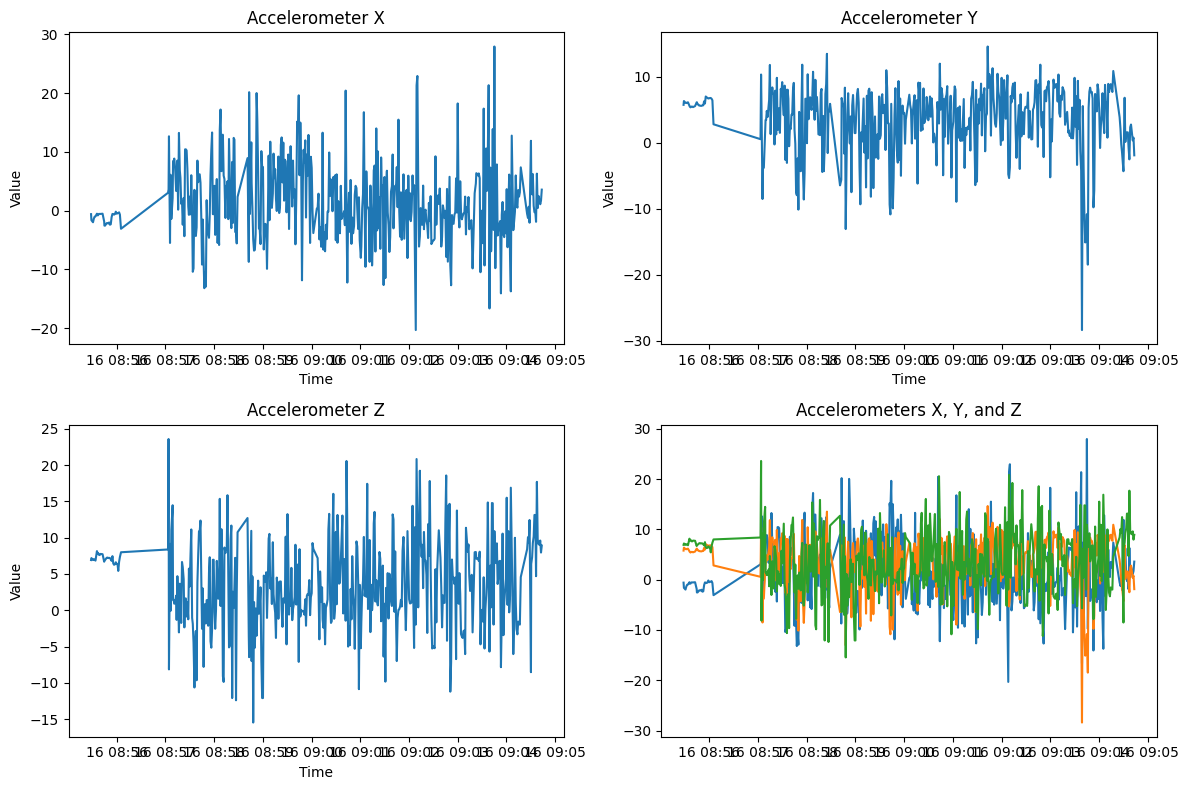

In [2]:

# Load the data
accelerometer_x = pd.read_csv('vivo Y15C Thing-Accelerometer_X.csv')
accelerometer_y = pd.read_csv('vivo Y15C Thing-Accelerometer_Y.csv')
accelerometer_z = pd.read_csv('vivo Y15C Thing-Accelerometer_Z.csv')

accelerometer_x.time = pd.to_datetime(accelerometer_x.time)
accelerometer_y.time = pd.to_datetime(accelerometer_y.time)
accelerometer_z.time = pd.to_datetime(accelerometer_z.time)

# Plotting accelerometer_x
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(accelerometer_x['time'], accelerometer_x['value'])
plt.title('Accelerometer X')

# Plotting accelerometer_y
plt.subplot(2, 2, 2)
plt.plot(accelerometer_y['time'], accelerometer_y['value'])
plt.title('Accelerometer Y')

# Plotting accelerometer_z
plt.subplot(2, 2, 3)
plt.plot(accelerometer_z['time'], accelerometer_z['value'])
plt.title('Accelerometer Z')

# Plotting all three accelerometers
plt.subplot(2, 2, 4)
plt.plot(accelerometer_x['time'], accelerometer_x['value'], label='X')
plt.plot(accelerometer_y['time'], accelerometer_y['value'], label='Y')
plt.plot(accelerometer_z['time'], accelerometer_z['value'], label='Z')
plt.title('Accelerometers X, Y, and Z')


for i in range(3):
    plt.subplot(2,2,i+1)
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [8]:
### Receiving the data from Python

In [5]:

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='live-update-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0)  # Update every second  
])

@app.callback(
    Output('live-update-graph', 'figure'),
    Input('interval-component', 'n_intervals')
)

def update_graph(n_intervals):
    global cur_data
    # Convert to DataFrame for Plotly
    df = pd.DataFrame(cur_data, columns=['index','Timestamp', 'X', 'Y', 'Z'])
    fig = px.line(df, x= 'Timestamp', y = ['X','Y','Z'])  # Scatter plot

    return fig

In [1]:
import sys
import time
import traceback
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from arduino_iot_cloud import ArduinoCloudClient
from datetime import datetime

# Arduino Cloud Credentials
DEVICE_ID = "27934dcd-77b7-4e70-b8d8-c0fc4120a3d0"
SECRET_KEY = "Vly02#Dp#yFGi5uCnCljd4jkx"

# Data holders
temp_data = []
x, y, z = 0, 0, 0
count = 0
N_SAMPLES = 20  # Change to 1000+ for real use

# Callback functions
def on_accelerometer_x_changed(client, value):
    global x
    x = value

def on_accelerometer_y_changed(client, value):
    global y
    y = value

def on_accelerometer_z_changed(client, value):
    global z
    z = value

# Main block
if __name__ == "__main__":
    try:
        os.makedirs("images", exist_ok=True)

        # Connect to Arduino IoT Cloud
        client = ArduinoCloudClient(
            device_id=DEVICE_ID,
            username=DEVICE_ID,
            password=SECRET_KEY,
            sync_mode=True
        )

        # Register variables
        client.register("py_X", value=None, on_write=on_accelerometer_x_changed)
        client.register("py_Y", value=None, on_write=on_accelerometer_y_changed)
        client.register("py_Z", value=None, on_write=on_accelerometer_z_changed)

        client.start()

        while True:
            if x is not None and y is not None and z is not None:
                if count < N_SAMPLES:
                    count += 1
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                    temp_data.append([count, timestamp, x, y, z])
                    print([count, timestamp, x, y, z])
                    x, y, z = None, None, None
                else:
                    # Save and exit after 1 batch
                    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                    df = pd.DataFrame(temp_data, columns=['Index', 'Timestamp', 'X', 'Y', 'Z'])

                    # Save CSV
                    df.to_csv(f"csv_{timestamp}.csv", index=False)

                    # Save HTML (interactive Plotly)
                    fig = px.line(df, x='Timestamp', y=['X', 'Y', 'Z'], title='Accelerometer Data')
                    fig.write_html(f"images/plot_{timestamp}.html")

                    # Save PNG (matplotlib)
                    plt.figure(figsize=(10, 5))
                    plt.plot(df['Timestamp'], df['X'], label='X')
                    plt.plot(df['Timestamp'], df['Y'], label='Y')
                    plt.plot(df['Timestamp'], df['Z'], label='Z')
                    plt.xticks(rotation=45)
                    plt.legend()
                    plt.title('Accelerometer Data (Matplotlib)')
                    plt.xlabel('Timestamp')
                    plt.ylabel('Acceleration')
                    plt.tight_layout()
                    plt.savefig(f"images/plot_{timestamp}.png")
                    plt.close()

                    print(f"✅ Data saved successfully to CSV and graphs at timestamp {timestamp}")
                    break  # Exit the loop

            client.update()

    except Exception as e:
        print("An error occurred:", e)
        traceback.print_exc()


[1, '2025-04-22 09:59:34', 0, 0, 0]
[2, '2025-04-22 09:59:35', -12.927000999450684, -1.7320500612258911, 10.020000457763672]
[3, '2025-04-22 09:59:36', 19.4809513092041, 7.843950271606445, 3.430950164794922]
[4, '2025-04-22 09:59:38', 2.356950044631958, 1.5610500574111938, 5.844000339508057]
[5, '2025-04-22 09:59:39', 5.689950466156006, 1.8679500818252563, 7.606950283050537]
[6, '2025-04-22 09:59:40', -13.464000701904297, -3.8010001182556152, 2.512050151824951]
[7, '2025-04-22 09:59:41', 5.920050144195557, -0.12300000339746475, 7.4920501708984375]
[8, '2025-04-22 09:59:42', -7.794000148773193, -2.6899502277374268, 4.006050109863281]
[9, '2025-04-22 09:59:43', 9.979950904846191, 8.457000732421875, 6.0360002517700195]
[10, '2025-04-22 09:59:44', -6.6060004234313965, 7.959000587463379, -1.8930001258850098]
[11, '2025-04-22 09:59:45', -19.171951293945312, -0.35295000672340393, -2.428950071334839]
[12, '2025-04-22 09:59:46', -20.283000946044922, 0.48900002241134644, 2.932950258255005]
[13, 

In [ ]:
app.run_server(debug_mode = True, jupyter_tab = True)

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\dash\dash.py", li

In [8]:
import pandas as pd
_df = pd.read_csv("dataplot.csv")
_df.drop(columns=[col for col in ["Unnamed: 0", "index"] if col in _df.columns], inplace=True)
_df.Timestamp = pd.to_datetime(_df.Timestamp)
_df.set_index("Timestamp", inplace=True)
print(_df.head())


                     Index          X        Y         Z
Timestamp                                               
2025-04-22 09:59:34      1   0.000000  0.00000   0.00000
2025-04-22 09:59:35      2 -12.927001 -1.73205  10.02000
2025-04-22 09:59:36      3  19.480951  7.84395   3.43095
2025-04-22 09:59:38      4   2.356950  1.56105   5.84400
2025-04-22 09:59:39      5   5.689950  1.86795   7.60695


In [12]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("dataplot.csv")  # Replace with your actual filename

# Step 2: Convert 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Set 'Timestamp' as the index
df.set_index('Timestamp', inplace=True)

# Step 4: Filter by time using between_time
act_1 = df.between_time("09:59:34", "09:59:35")
act_2 = df.between_time("09:59:36", "09:59:37")
act_3 = df.between_time("09:59:38", "09:59:40")
act_4 = df.between_time("09:59:41", "09:59:43")
act_5 = df.between_time("09:59:44", "09:59:46")
act_6 = df.between_time("09:59:47", "09:59:49")
act_7 = df.between_time("09:59:50", "09:59:52")
act_8 = df.between_time("09:59:53", "09:59:55")
act_9 = df.between_time("09:59:56", "09:59:57")



In [13]:
act_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2025-04-22 09:59:34 to 2025-04-22 09:59:35
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   2 non-null      int64  
 1   X       2 non-null      float64
 2   Y       2 non-null      float64
 3   Z       2 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 80.0 bytes


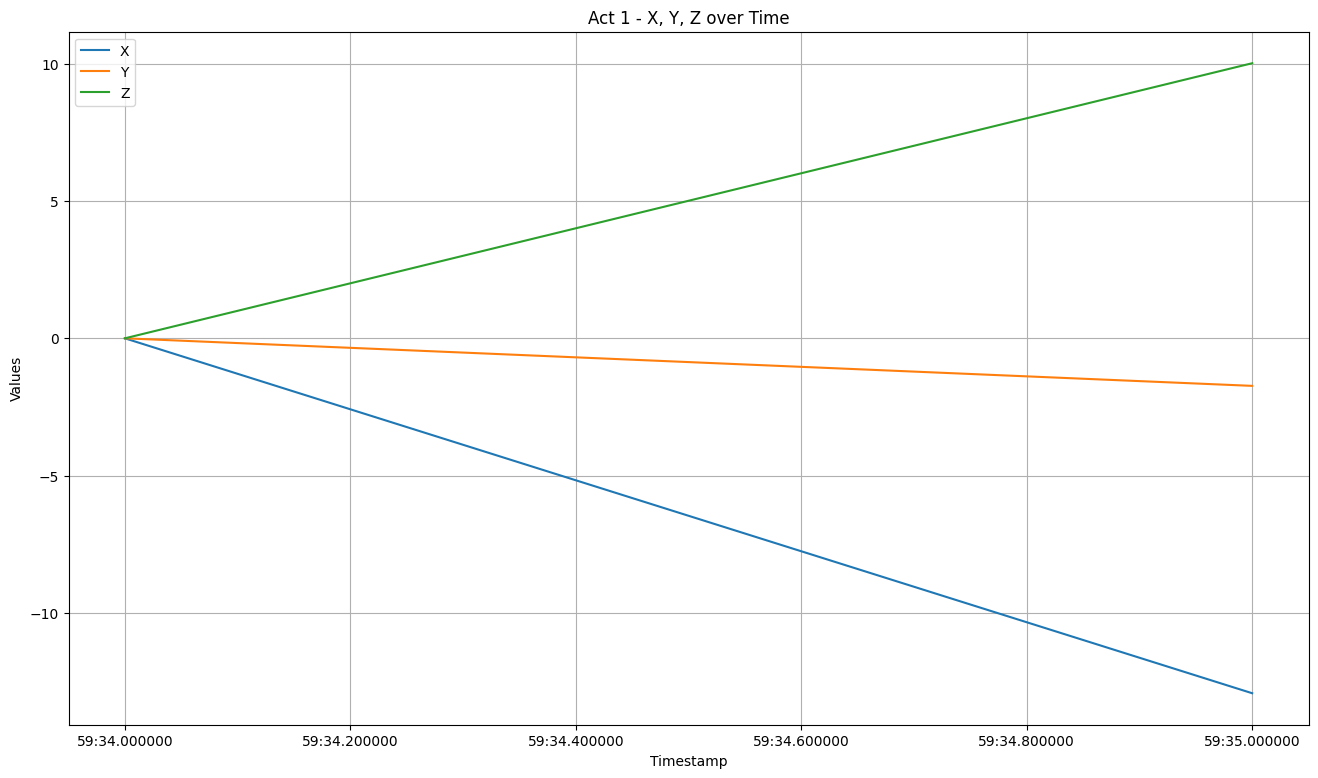

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

sns.lineplot(x=act_1.index, y=act_1["X"], label="X")
sns.lineplot(x=act_1.index, y=act_1["Y"], label="Y")
sns.lineplot(x=act_1.index, y=act_1["Z"], label="Z")

plt.title("Act 1 - X, Y, Z over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()


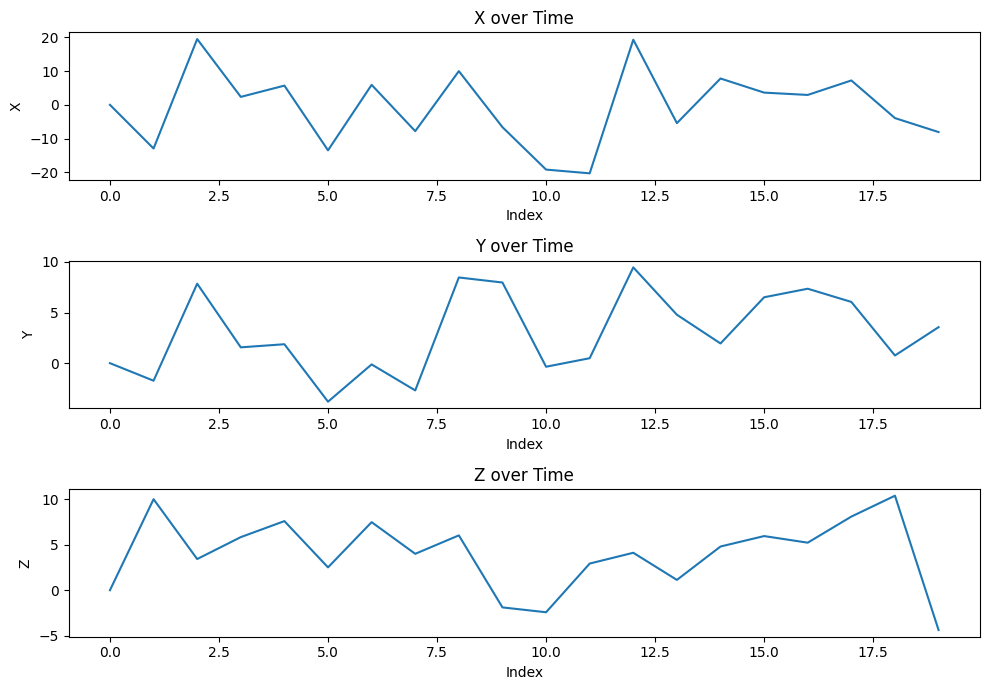

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (change filename if needed)
ydata = pd.read_csv("dataplot.csv")  # Replace with actual file path if needed

# Optional: Set the Timestamp as index if you want time on x-axis
# ydata['Timestamp'] = pd.to_datetime(ydata['Timestamp'])
# ydata.set_index('Timestamp', inplace=True)

# Use the DataFrame's index or Timestamp for the x-axis
x_axis = ydata.index  # or ydata['Timestamp'] if datetime index used

fig, axs = plt.subplots(3, figsize=(10, 7))  # 3 plots for X, Y, Z

columns_to_plot = ['X', 'Y', 'Z']

for i, col in enumerate(columns_to_plot):
    if col in ydata.columns:
        sns.lineplot(x=x_axis, y=ydata[col], ax=axs[i])
        axs[i].set_title(f'{col} over Time')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel(col)
    else:
        axs[i].text(0.5, 0.5, f'Missing column: {col}', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=axs[i].transAxes)
        axs[i].set_title('Data Missing')
        axs[i].set_xticks([])
        axs[i].set_yticks([])

plt.tight_layout()
plt.show()


In [16]:
act_1.describe()


Index          X         Y         Z
count  2.000000   2.000000  2.000000   2.00000
mean   1.500000  -6.463500 -0.866025   5.01000
std    0.707107   9.140770  1.224744   7.08521
min    1.000000 -12.927001 -1.732050   0.00000
25%    1.250000  -9.695251 -1.299038   2.50500
50%    1.500000  -6.463500 -0.866025   5.01000
75%    1.750000  -3.231750 -0.433013   7.51500
max    2.000000   0.000000  0.000000  10.02000

In [17]:
act_2.describe()


Index          X        Y        Z
count    1.0   1.000000  1.00000  1.00000
mean     3.0  19.480951  7.84395  3.43095
std      NaN        NaN      NaN      NaN
min      3.0  19.480951  7.84395  3.43095
25%      3.0  19.480951  7.84395  3.43095
50%      3.0  19.480951  7.84395  3.43095
75%      3.0  19.480951  7.84395  3.43095
max      3.0  19.480951  7.84395  3.43095

In [18]:
act_3.describe()

Index          X         Y         Z
count    3.0   3.000000  3.000000  3.000000
mean     5.0  -1.805700 -0.124000  5.321000
std      1.0  10.232996  3.188071  2.587402
min      4.0 -13.464001 -3.801000  2.512050
25%      4.5  -5.553525 -1.119975  4.178025
50%      5.0   2.356950  1.561050  5.844000
75%      5.5   4.023450  1.714500  6.725475
max      6.0   5.689950  1.867950  7.606950

In [19]:
act_4.describe()

Index         X         Y         Z
count    3.0  3.000000  3.000000  3.000000
mean     8.0  2.702000  1.881350  5.844700
std      1.0  9.313711  5.837525  1.750856
min      7.0 -7.794000 -2.689950  4.006050
25%      7.5 -0.936975 -1.406475  5.021025
50%      8.0  5.920050 -0.123000  6.036000
75%      8.5  7.950001  4.167000  6.764025
max      9.0  9.979951  8.457001  7.492050

In [21]:
act_5.describe()

Index          X         Y         Z
count    3.0   3.000000  3.000000  3.000000
mean    11.0 -15.353651  2.698350 -0.463000
std      1.0   7.596029  4.575265  2.953163
min     10.0 -20.283001 -0.352950 -2.428950
25%     10.5 -19.727476  0.068025 -2.160975
50%     11.0 -19.171951  0.489000 -1.893000
75%     11.5 -12.888976  4.224000  0.519975
max     12.0  -6.606000  7.959001  2.932950

In [22]:
act_6.describe()

Index          X         Y         Z
count    3.0   3.000000  3.000000  3.000000
mean    14.0   7.222300  5.392000  3.354650
std      1.0  12.364022  3.791846  1.954655
min     13.0  -5.419050  1.944000  1.132950
25%     13.5   1.188975  3.361500  2.626950
50%     14.0   7.797000  4.779000  4.120950
75%     14.5  13.542975  7.116000  4.465500
max     15.0  19.288950  9.453000  4.810050

In [23]:
act_7.describe()

Index      X        Y        Z
count    1.0  1.000  1.00000  1.00000
mean    16.0  3.621  6.50295  5.95905
std      NaN    NaN      NaN      NaN
min     16.0  3.621  6.50295  5.95905
25%     16.0  3.621  6.50295  5.95905
50%     16.0  3.621  6.50295  5.95905
75%     16.0  3.621  6.50295  5.95905
max     16.0  3.621  6.50295  5.95905

In [24]:
act_8.describe()

Index         X        Y          Z
count    3.0  3.000000  3.00000   3.000000
mean    18.0  2.076000  4.71535   7.913300
std      1.0  5.622520  3.48934   2.590797
min     17.0 -3.925050  0.75705   5.232000
25%     17.5 -0.497025  3.40005   6.668475
50%     18.0  2.931000  6.04305   8.104950
75%     18.5  5.076525  6.69450   9.253950
max     19.0  7.222050  7.34595  10.402950

In [25]:
act_9.describe()

Index         X        Y      Z
count    1.0  1.000000  1.00000  1.000
mean    20.0 -8.062051  3.55305 -4.383
std      NaN       NaN      NaN    NaN
min     20.0 -8.062051  3.55305 -4.383
25%     20.0 -8.062051  3.55305 -4.383
50%     20.0 -8.062051  3.55305 -4.383
75%     20.0 -8.062051  3.55305 -4.383
max     20.0 -8.062051  3.55305 -4.383